In [1]:
import torch
import torchvision
import os
import cv2
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision.transforms import v2
from utils import im_to_txt_path, imread, isfile, imwrite
from dataset_operations import clip_value,read_mean_std
import matplotlib.pyplot as plt
import torch.nn as nn
import random

parent_dir = 'rois2/'
obj_dir = parent_dir + 'objects/'
img_dir = parent_dir + 'images/'
label_dir = parent_dir + 'labels/'
model_dir = parent_dir + 'models/'

obj_train_dir = obj_dir + 'train/'
obj_val_dir = obj_dir + 'val/'
false_positive_label_dir = parent_dir + 'tiles/false_positives/labels/'
if not os.path.exists(obj_dir):
    os.makedirs(obj_dir)

In [2]:
mean_std_dict = pickle.load(open(obj_dir + 'mean_std.pkl', 'rb'))
print(mean_std_dict)

{'expert1_id-6381471f7f8a5e686a52765f_left-36214_top-41262_right-39265_bottom-46232': (array([0.88391932, 0.86455804, 0.84128348]), array([0.08340014, 0.09904173, 0.12370593])), 'expert1_id-6381471f7f8a5e686a52765f_left-36627_top-47431_right-39464_bottom-52356': (array([0.8841721 , 0.86190506, 0.83281352]), array([0.08451419, 0.10180634, 0.1258441 ])), 'expert1_id-6381471f7f8a5e686a527706_left-75035_top-24698_right-80405_bottom-28610': (array([0.86614397, 0.84570188, 0.82592797]), array([0.10124425, 0.11657547, 0.1331032 ])), 'expert1_id-6381471f7f8a5e686a5277c2_left-68060_top-39334_right-73669_bottom-44184': (array([0.89545478, 0.87718601, 0.86096679]), array([0.06975292, 0.08177992, 0.09553303])), 'expert1_id-6381471f7f8a5e686a52781f_left-70416_top-29678_right-75686_bottom-33272': (array([0.81283723, 0.75033681, 0.66633584]), array([0.12331021, 0.1447023 , 0.17060996])), 'expert1_id-638147207f8a5e686a527923_left-84307_top-28200_right-89535_bottom-31674': (array([0.71946232, 0.6813055

Load datasets & dataloader

In [3]:
ratio = []
dirs = os.listdir(obj_train_dir)
for dir in dirs:
    if os.path.isdir(obj_train_dir+ dir):
        # print(len(os.listdir(obj_dir + dir)))
        ratio.append(len(os.listdir(obj_train_dir + dir)))
print(ratio)


[2871, 11436, 67429]


In [4]:
from PIL import Image
def custom_loader(path):
    return path

orig_train_dataset = datasets.ImageFolder(root=obj_train_dir,loader=custom_loader)

orig_val_dataset = datasets.ImageFolder(root=obj_val_dir,loader=custom_loader)

In [5]:
def crop_name_to_roi_name(crop_name):
    return (crop_name.split('__')[0]).split('\\')[-1]

In [6]:
from collections import Counter
class_num = len(orig_train_dataset.classes)

In [7]:
# print('train dataset: ')
# print('     unbalanced:')

# class_counts = Counter([label for _, label in orig_train_dataset.samples])
# max_count = max(class_counts.values())
# print('     ', class_counts)

# print('     balanced:')
# import random
# # Create a new dataset to store balanced data
# balanced_train_dataset = []

# for label in class_counts:
#     indices = [i for i, (_, lbl) in enumerate(orig_train_dataset.samples) if lbl == label]
    
#     # Calculate how many more samples are needed to balance the class
#     additional_samples_needed = max_count - class_counts[label]
    
#     # Oversample the class by randomly duplicating images
#     if additional_samples_needed > 0:
#         additional_samples = random.choices(indices, k=additional_samples_needed)
#         indices.extend(additional_samples)
    
#     balanced_train_dataset.extend([orig_train_dataset[i] for i in indices])

# # Shuffle the balanced dataset
# random.shuffle(balanced_train_dataset)
# class_counts = Counter([label for _, label in balanced_train_dataset])
# print('     ', class_counts)


train dataset: 
     unbalanced:
      Counter({2: 67429, 1: 11436, 0: 2871})
     balanced:
      Counter({1: 67429, 2: 67429, 0: 67429})


In [8]:
class_counts = Counter([label for _, label in orig_val_dataset.samples])
print('val dataset: ')
print('     ',class_counts)

test dataset: 
      Counter({2: 13653, 1: 2259, 0: 653})


In [9]:
class CustomDataset(Dataset):

    def __init__(self, inputs_list_pos, inputs_list_neg, length):
        
        self.positives = inputs_list_pos
        self.negatives = inputs_list_neg
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(self.inputs_list[idx])
        item = random.choice([random.choice(self.positives), random.choice(self.negatives)])
        path = item[0]
        roi_name = crop_name_to_roi_name(path)
        if roi_name in mean_std_dict.keys():
            mean, std = mean_std_dict[roi_name]
        else:
            print('mean std not found')
            print(roi_name)
            
        label = item[1]
        image = Image.open(path)
        
        transf = v2.Compose([
            v2.ToImage(), 
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize((260,260)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomAffine(degrees=(0,90), translate=(0.1,0.3), scale=(0.5,0.75)),
            v2.Normalize(mean=mean, std=std), # aim to make the mean = 0 and std = 1
           
        ])
        image = transf(image)

        return image, label

In [ ]:
train_dataset_positives = []
train_dataset_negatives = []
for item in orig_train_dataset.samples:
    if item[1] == 1:
        train_dataset_positives.append(item)
    else:
        train_dataset_negatives.append(item)

val_dataset_positives = []
val_dataset_positives = []
for item in orig_val_dataset.samples:
    if item[1] == 1:
        val_dataset_positives.append(item)
    else:
        val_dataset_positives.append(item)
        

train_dataset = CustomDataset(train_dataset_positives, train_dataset_negatives,32000)

val_dataset = CustomDataset(val_dataset_positives, val_dataset_positives, 6400)

In [10]:
# number in classes/types for background class
bkg = 0

In [11]:
train_loader, val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False), DataLoader(val_dataset, batch_size=32, shuffle=False)
print('train loader length: ', len(train_loader))
print('test loader length: ', len(val_loader))

train loader length:  6322
test loader length:  518


In [12]:
pickle.dump(train_loader, open(model_dir + 'round3_train_loader.pkl', 'wb'))
pickle.dump(val_loader, open(model_dir + 'round3_val_loader.pkl', 'wb'))

Set up the model and train

In [13]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

def train_classification_model(model, train_loader, val_loader, save_model_dir, begin_epoch = 1,num_epochs=20,class_weights=None, train = True, val = True):
    
    accuracy_list = [None]*num_epochs
    precision_list = [None]*num_epochs
    recall_list = [None]*num_epochs
    train_loss_list = [None]*num_epochs
    learning_rate_list = [None]*num_epochs
    
    model.to('cuda')
    criterion = torch.nn.CrossEntropyLoss(weight = class_weights).to('cuda')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3
                                  , weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    if begin_epoch > 1:
        model.load_state_dict(torch.load(save_model_dir + 'round3_model_epoch' + str(begin_epoch-1) + '.pth'))
    for epoch in range(begin_epoch, begin_epoch + num_epochs):
        if train:
            # Train the model
            model.train()
            train_loss = 0
            cnt = 0 
            print('Training model...')
            for i, (images, labels) in enumerate(train_loader):
                images = images.to('cuda')
                labels = labels.to('cuda')
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs.float(), labels)
                
                train_loss += loss.item()
                cnt += 1
                
                loss.backward()
                optimizer.step()
                model_path = save_model_dir + 'round3_model_epoch' + str(epoch) + '.pth'
                
                if (i + 1)%100 == 0 or i == len(train_loader)-1:
                    print('     Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Learning Rate: {}'
                        .format(epoch, num_epochs, i+1, len(train_loader), loss.item(), optimizer.param_groups[0]['lr']))
            train_loss /= cnt
            train_loss_list[epoch-1] = train_loss
            learning_rate_list[epoch-1] = optimizer.param_groups[0]['lr']
            torch.save(model.state_dict(), model_path)
        
        if val:    
            # Validation
            model.eval()
            print('Validation...')
            
            # Calculate accuracy
            correct = 0
            total = 0
            # Calculate recall
            correct_pos_pred = 0
            true_pos_obj = 0
            pos_pred = 0
            with torch.no_grad():
                for i, (images, labels) in enumerate(val_loader):
                    images = images.to('cuda')
                    labels = labels.to('cuda')
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    true_pos_obj += (labels != bkg).sum().item()
                    correct_pos_pred += ((predicted == labels) & (labels != bkg)).sum().item()
                    pos_pred += (predicted != bkg).sum().item()
                    
                    if(i+1) % 100 == 0 or i == len(val_loader)-1:
                        print('     Epoch [{}/{}], Image [{}/{}], Accuracy: {:.2f} %, Recall: {:.2f} %'
                                .format(epoch, num_epochs, i+1, len(val_loader), 100 * correct / total, 100 * correct / total))
                    
                    
            print('Accuracy of the network on the validation images: {} % \n'.format(100 * correct / total))
            print('Recall of the network on the validation images: {} % \n'.format(100 * correct_pos_pred / true_pos_obj))
            print('Precision of the network on the validation images: {} % \n'.format(100 * correct_pos_pred / pos_pred))    
            accuracy_list[epoch-1] = correct / total
            pickle.dump(accuracy_list, open(save_model_dir + 'accuracy_list.pkl', 'wb'))
            recall_list[epoch-1] = correct_pos_pred / true_pos_obj
            pickle.dump(recall_list, open(save_model_dir + 'recall_list.pkl', 'wb'))
            precision_list[epoch-1] = correct_pos_pred / pos_pred
            pickle.dump(precision_list, open(save_model_dir + 'precision_list.pkl', 'wb'))
            scheduler.step()
            
            list = np.arange(begin_epoch, begin_epoch + num_epochs)
            plt.figure(figsize=(10, 8))
            ax1 = plt.subplot(2, 1, 1)
            plt.xticks(list)
            
            ax1.set_xlabel('Epoch')
            
            ax1.set_ylabel('Percentage')
            ax1.plot(list, accuracy_list, marker='o',label = 'Accuracy', color='tab:red')
            ax1.plot(list, recall_list, marker='o', label = 'Recall', color='tab:orange')
            ax1.plot(list, precision_list, marker='o', label = 'Precision', color='tab:blue')
            ax1.tick_params(axis='y')
            
            ax2 = ax1.twinx()
            ax2.set_ylabel('Learning rate', color='tab:green')
            ax2.plot(list, learning_rate_list, marker='o', label = 'Learning rate', color='tab:green')
            ax2.tick_params(axis='y', labelcolor='tab:green')
            
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')
            
            plt.subplot(2, 1, 2)
            plt.plot(list, train_loss_list, marker='o', label = 'Train loss', color='tab:green')
            plt.xlabel('Epoch')
            plt.ylabel('Loss', color='tab:green')
            plt.xticks(list)
            plt.tight_layout()
            plt.show()
            
            plt.close('all')
        
        

In [14]:
model = torchvision.models.efficientnet_b1().to('cuda')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, class_num).to('cuda')
# model.load_state_dict(torch.load('rois2/models/round3/2024_08_28_lr0.001 decay0.01 weight 1-5/round3_model_epoch17.pth'))


In [15]:
# # clean up false positive cam images
# import os
# import shutil
# dir = obj_dir + 'false_postives_cam/'
# if os.path.exists(dir):
#     shutil.rmtree(dir)
#     os.makedirs(dir)
# else:
#     os.makedirs(dir)

Training model...


d:\anaconda\envs\2024summer\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
d:\anaconda\envs\2024summer\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


     Epoch [1/30], Step [100/6322], Loss: 0.5482, Learning Rate: 0.001
     Epoch [1/30], Step [200/6322], Loss: 0.3515, Learning Rate: 0.001
     Epoch [1/30], Step [300/6322], Loss: 0.1929, Learning Rate: 0.001
     Epoch [1/30], Step [400/6322], Loss: 0.2075, Learning Rate: 0.001
     Epoch [1/30], Step [500/6322], Loss: 0.2509, Learning Rate: 0.001
     Epoch [1/30], Step [600/6322], Loss: 0.1941, Learning Rate: 0.001
     Epoch [1/30], Step [700/6322], Loss: 0.2072, Learning Rate: 0.001
     Epoch [1/30], Step [800/6322], Loss: 0.5219, Learning Rate: 0.001
     Epoch [1/30], Step [900/6322], Loss: 0.2626, Learning Rate: 0.001
     Epoch [1/30], Step [1000/6322], Loss: 0.2212, Learning Rate: 0.001
     Epoch [1/30], Step [1100/6322], Loss: 0.3051, Learning Rate: 0.001
     Epoch [1/30], Step [1200/6322], Loss: 0.5150, Learning Rate: 0.001
     Epoch [1/30], Step [1300/6322], Loss: 0.2006, Learning Rate: 0.001
     Epoch [1/30], Step [1400/6322], Loss: 0.2417, Learning Rate: 0.001
 

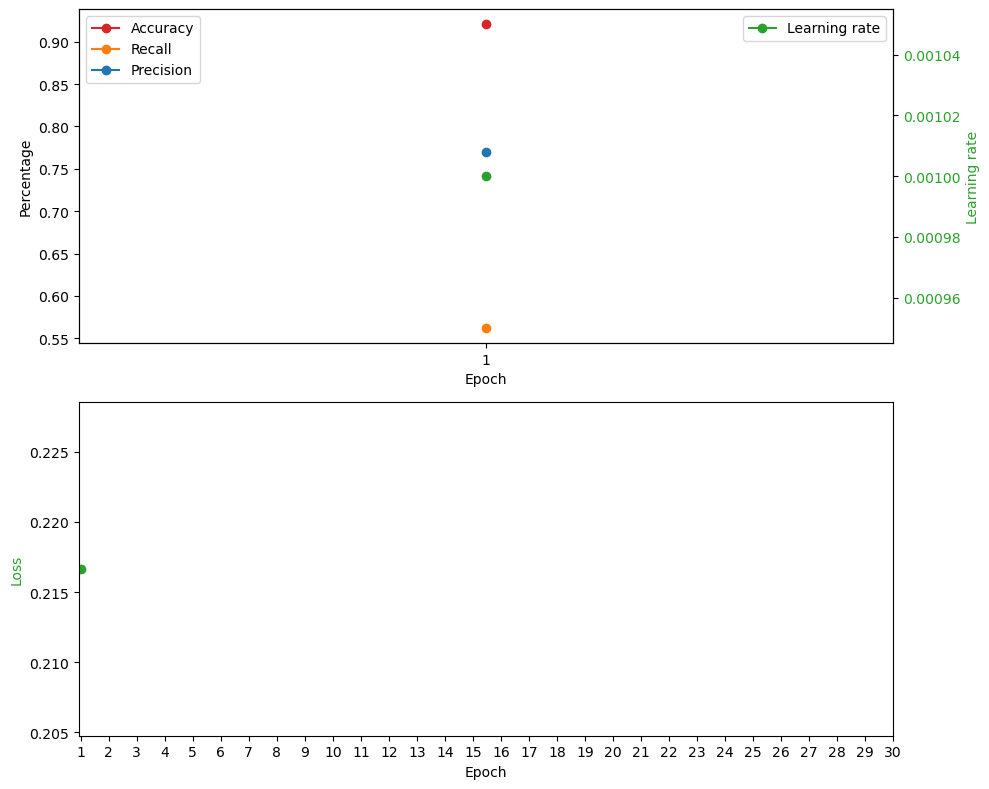

Training model...
     Epoch [2/30], Step [100/6322], Loss: 0.1175, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [200/6322], Loss: 0.0641, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [300/6322], Loss: 0.3514, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [400/6322], Loss: 0.1364, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [500/6322], Loss: 0.1771, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [600/6322], Loss: 0.1813, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [700/6322], Loss: 0.0829, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [800/6322], Loss: 0.1088, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [900/6322], Loss: 0.1574, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [1000/6322], Loss: 0.1461, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step [1100/6322], Loss: 0.0947, Learning Rate: 0.0009755527298894294
     Epoch [2/30], Step

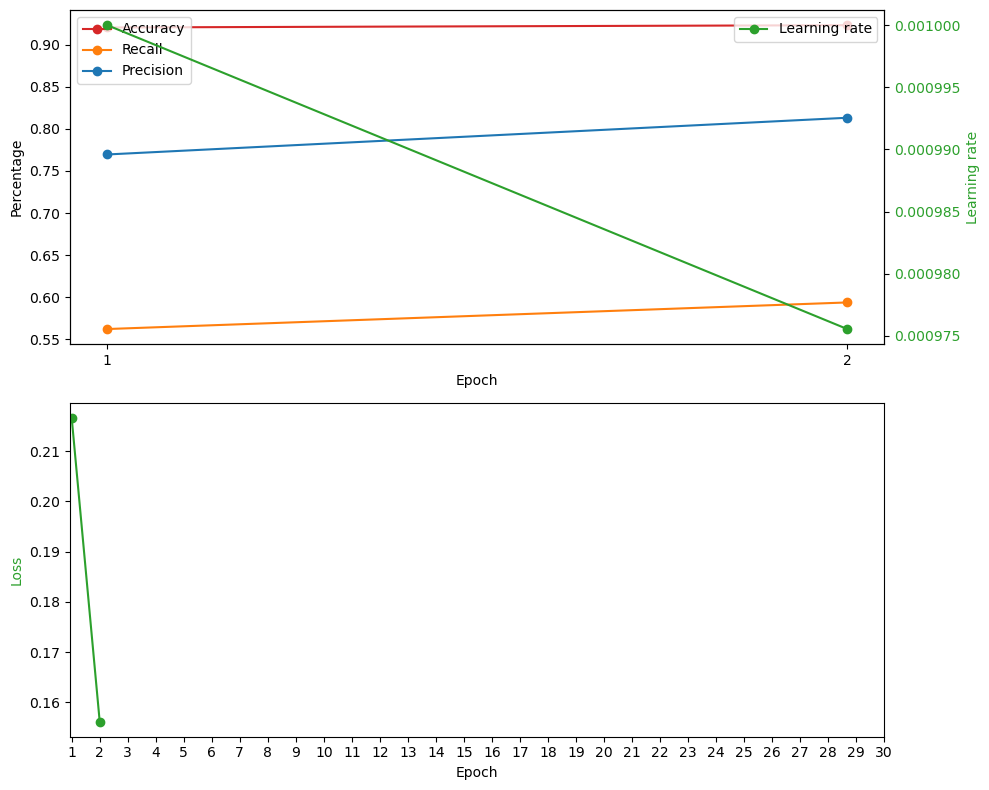

Training model...
     Epoch [3/30], Step [100/6322], Loss: 0.0736, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [200/6322], Loss: 0.1547, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [300/6322], Loss: 0.2730, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [400/6322], Loss: 0.0912, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [500/6322], Loss: 0.1917, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [600/6322], Loss: 0.0702, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [700/6322], Loss: 0.1096, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [800/6322], Loss: 0.0746, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [900/6322], Loss: 0.1514, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [1000/6322], Loss: 0.1204, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step [1100/6322], Loss: 0.0693, Learning Rate: 0.0009046039886902864
     Epoch [3/30], Step

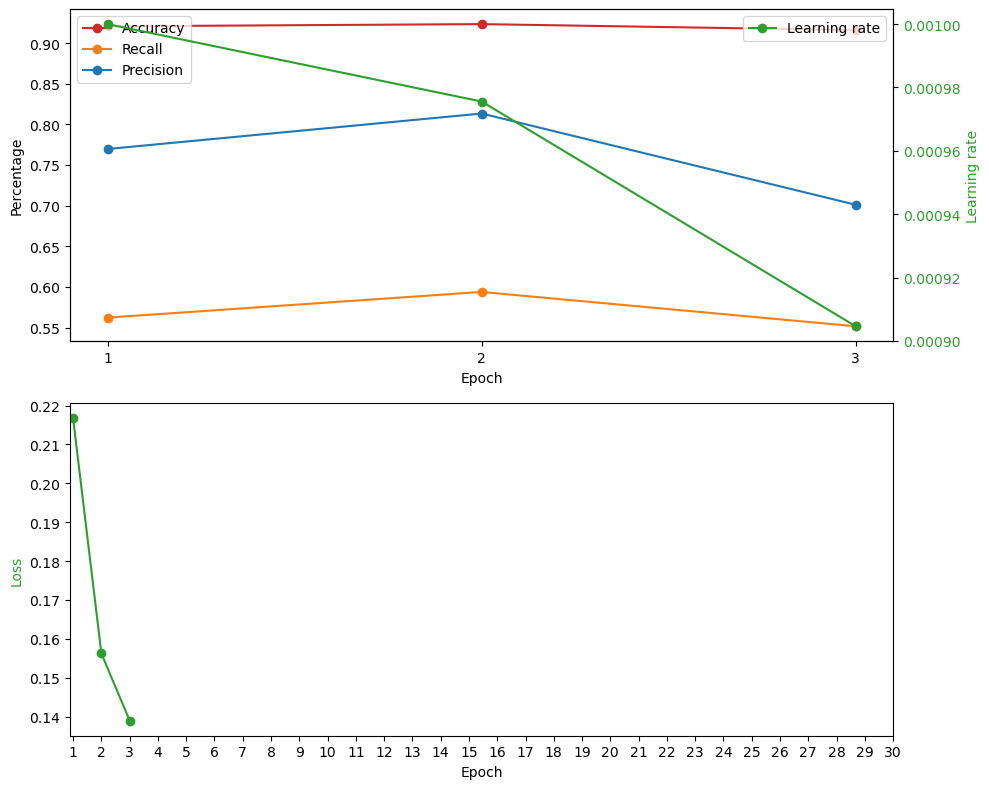

Training model...
     Epoch [4/30], Step [100/6322], Loss: 0.1343, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [200/6322], Loss: 0.0922, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [300/6322], Loss: 0.1318, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [400/6322], Loss: 0.1287, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [500/6322], Loss: 0.1067, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [600/6322], Loss: 0.0920, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [700/6322], Loss: 0.1357, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [800/6322], Loss: 0.0673, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [900/6322], Loss: 0.0896, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [1000/6322], Loss: 0.0939, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step [1100/6322], Loss: 0.2987, Learning Rate: 0.0007940987335200905
     Epoch [4/30], Step

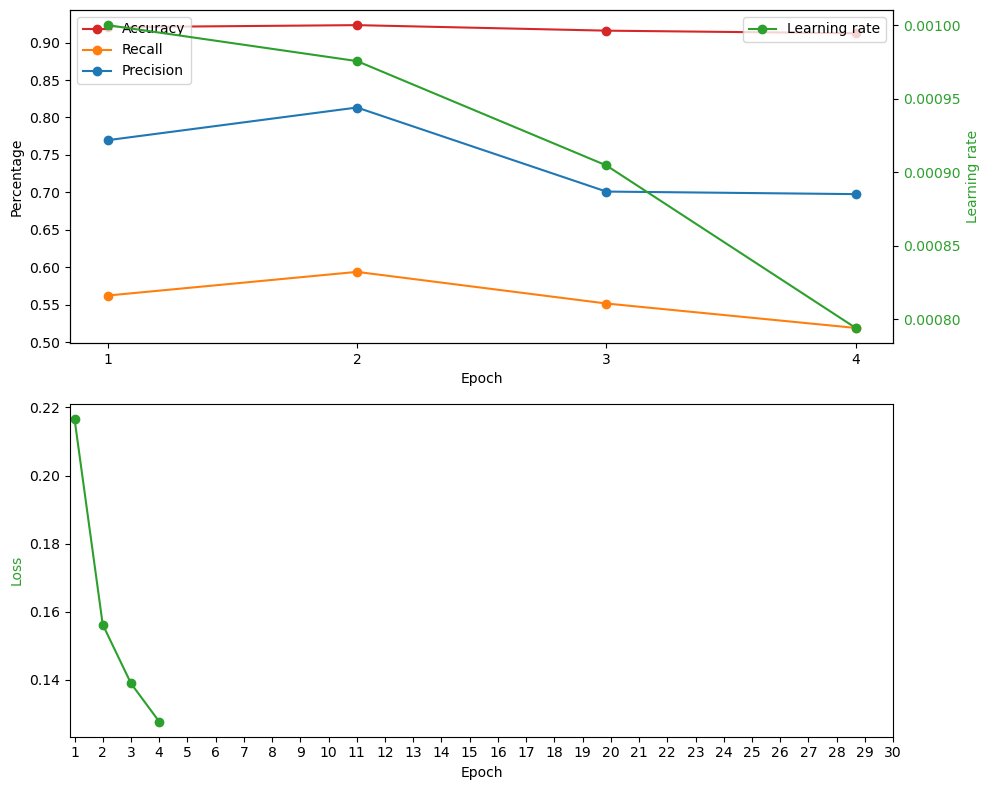

Training model...
     Epoch [5/30], Step [100/6322], Loss: 0.0972, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [200/6322], Loss: 0.3091, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [300/6322], Loss: 0.1811, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [400/6322], Loss: 0.1040, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [500/6322], Loss: 0.0799, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [600/6322], Loss: 0.2988, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [700/6322], Loss: 0.1465, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [800/6322], Loss: 0.0822, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [900/6322], Loss: 0.1037, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [1000/6322], Loss: 0.0705, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step [1100/6322], Loss: 0.1157, Learning Rate: 0.0006548539886902864
     Epoch [5/30], Step

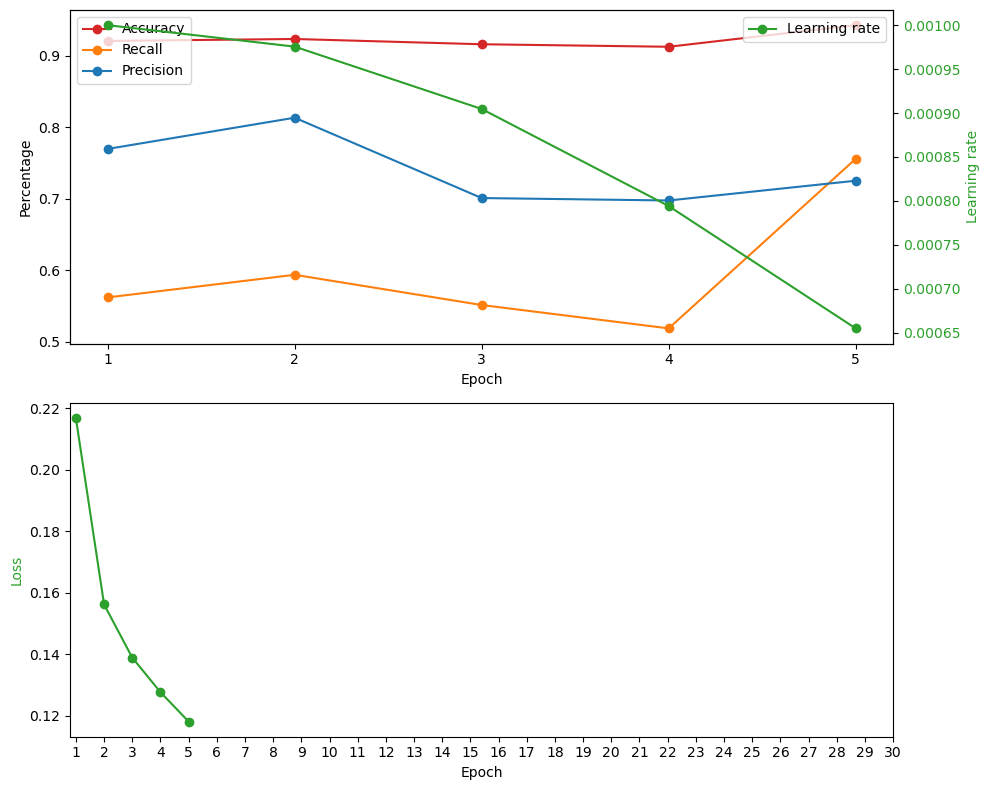

Training model...
     Epoch [6/30], Step [100/6322], Loss: 0.1027, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [200/6322], Loss: 0.1276, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [300/6322], Loss: 0.1283, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [400/6322], Loss: 0.0684, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [500/6322], Loss: 0.0398, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [600/6322], Loss: 0.0669, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [700/6322], Loss: 0.1782, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [800/6322], Loss: 0.0779, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [900/6322], Loss: 0.1023, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [1000/6322], Loss: 0.1229, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step [1100/6322], Loss: 0.1652, Learning Rate: 0.0005005000000000001
     Epoch [6/30], Step

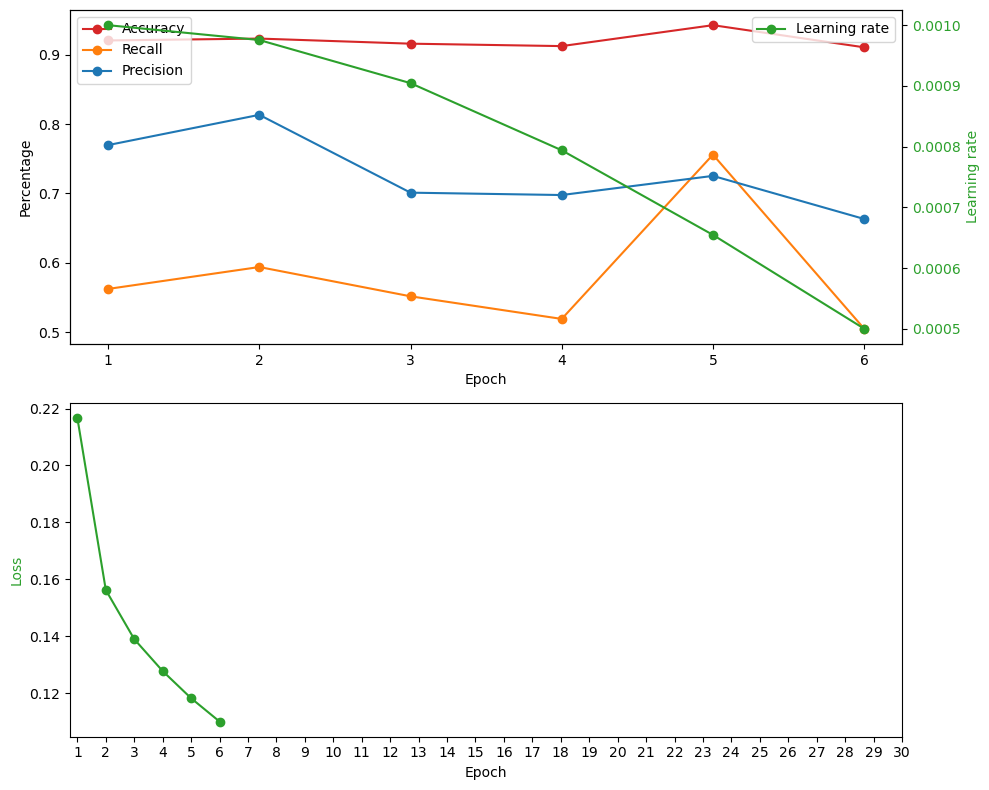

Training model...
     Epoch [7/30], Step [100/6322], Loss: 0.1337, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [200/6322], Loss: 0.1373, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [300/6322], Loss: 0.0894, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [400/6322], Loss: 0.0796, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [500/6322], Loss: 0.5756, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [600/6322], Loss: 0.0748, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [700/6322], Loss: 0.0923, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [800/6322], Loss: 0.0937, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [900/6322], Loss: 0.1320, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [1000/6322], Loss: 0.0729, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step [1100/6322], Loss: 0.0689, Learning Rate: 0.0003461460113097139
     Epoch [7/30], Step

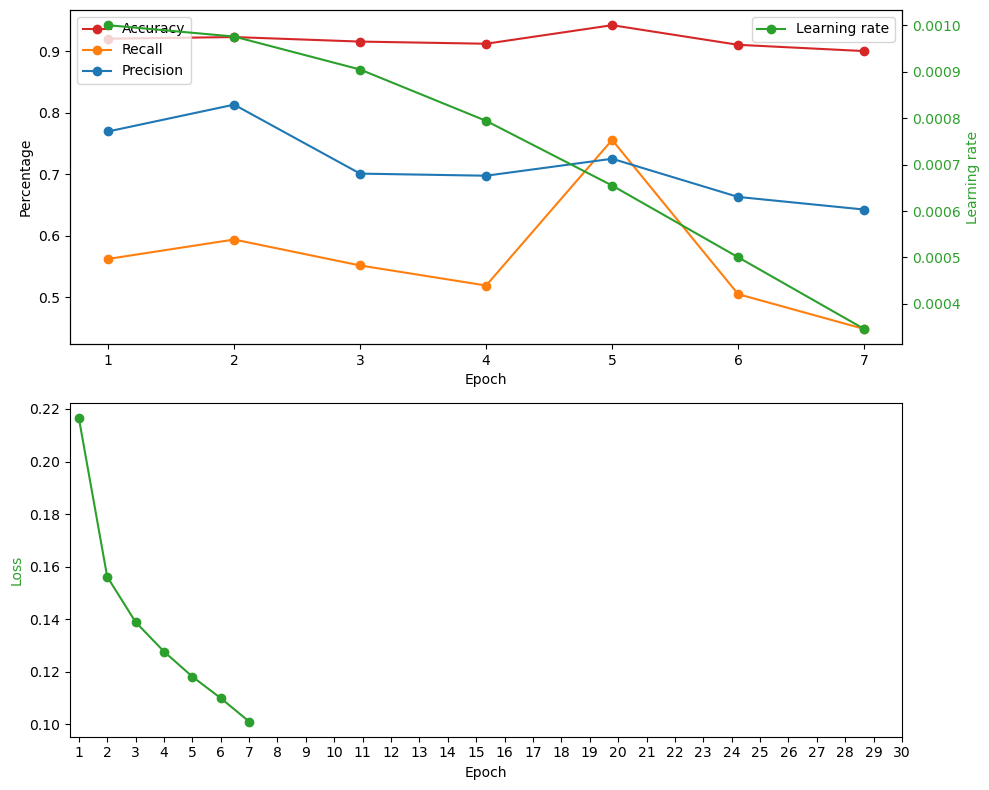

Training model...
     Epoch [8/30], Step [100/6322], Loss: 0.0681, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [200/6322], Loss: 0.1046, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [300/6322], Loss: 0.0476, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [400/6322], Loss: 0.0526, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [500/6322], Loss: 0.1409, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [600/6322], Loss: 0.0584, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [700/6322], Loss: 0.1051, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [800/6322], Loss: 0.0761, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [900/6322], Loss: 0.1043, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [1000/6322], Loss: 0.0565, Learning Rate: 0.00020690126647990976
     Epoch [8/30], Step [1100/6322], Loss: 0.0707, Learning Rate: 0.00020690126647990976
     Epoch [

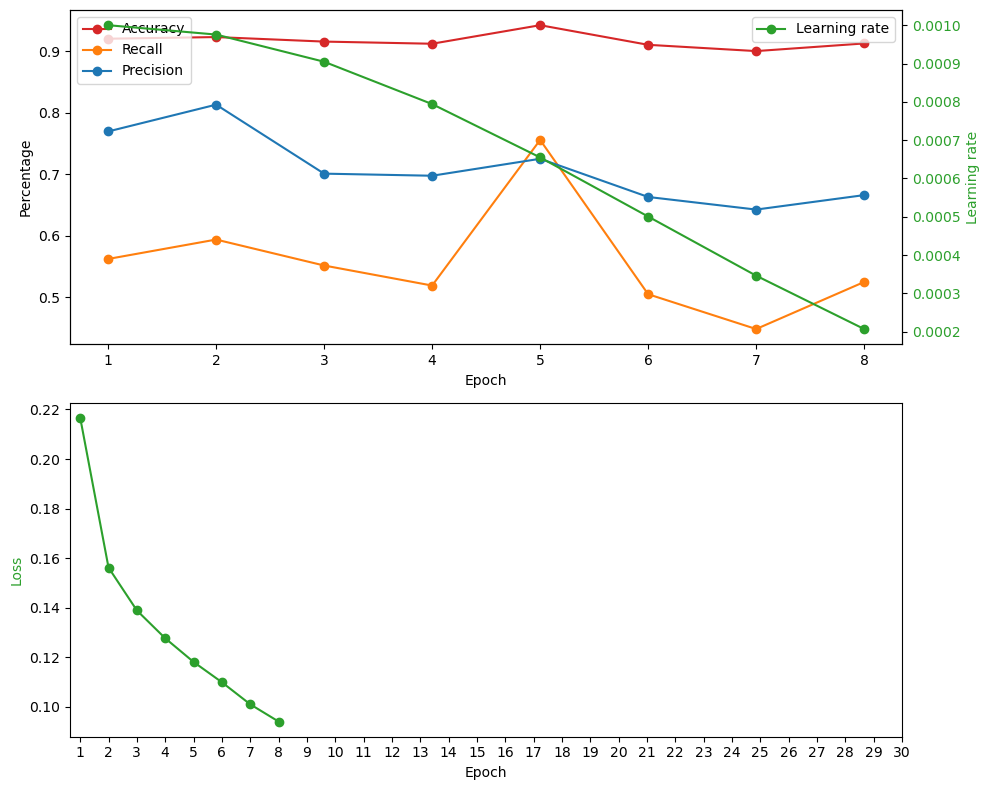

Training model...
     Epoch [9/30], Step [100/6322], Loss: 0.1477, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [200/6322], Loss: 0.0958, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [300/6322], Loss: 0.0813, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [400/6322], Loss: 0.0292, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [500/6322], Loss: 0.0775, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [600/6322], Loss: 0.1189, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [700/6322], Loss: 0.1477, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [800/6322], Loss: 0.0874, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [900/6322], Loss: 0.0691, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [1000/6322], Loss: 0.1111, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step [1100/6322], Loss: 0.0984, Learning Rate: 9.639601130971382e-05
     Epoch [9/30], Step

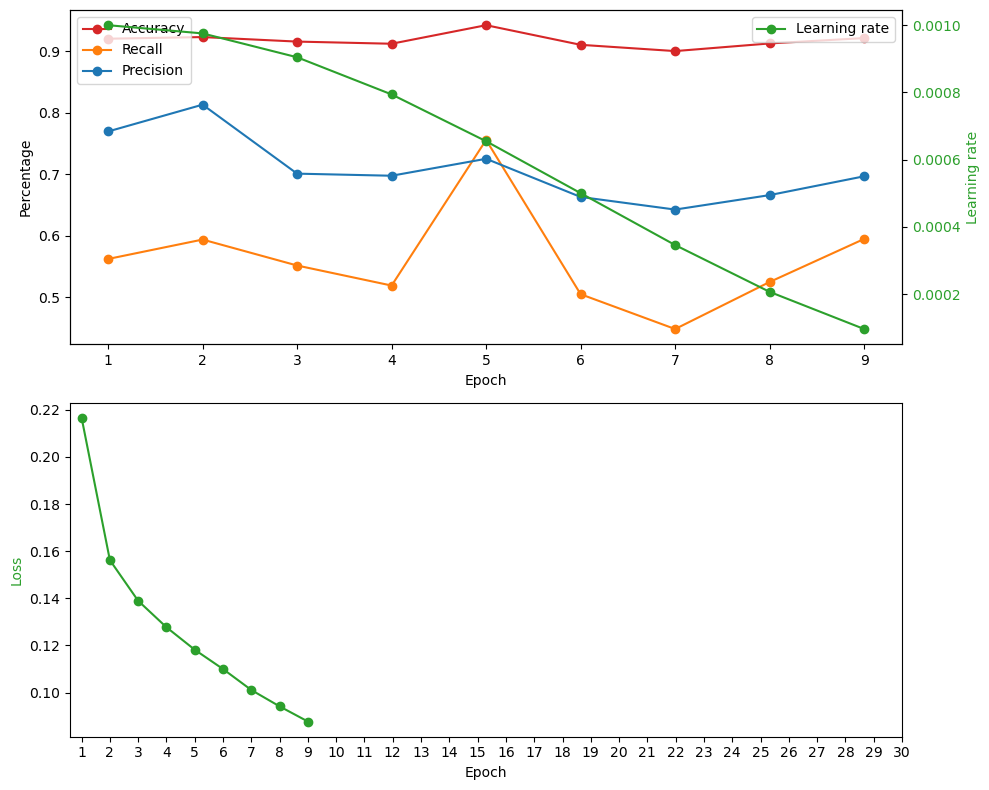

Training model...
     Epoch [10/30], Step [100/6322], Loss: 0.0602, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [200/6322], Loss: 0.0404, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [300/6322], Loss: 0.0376, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [400/6322], Loss: 0.0860, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [500/6322], Loss: 0.1044, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [600/6322], Loss: 0.1489, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [700/6322], Loss: 0.0630, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [800/6322], Loss: 0.1323, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [900/6322], Loss: 0.0739, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [1000/6322], Loss: 0.0352, Learning Rate: 2.5447270110570814e-05
     Epoch [10/30], Step [1100/6322], Loss: 0.0804, Learning Rate: 2.5447270110570814e-05
 

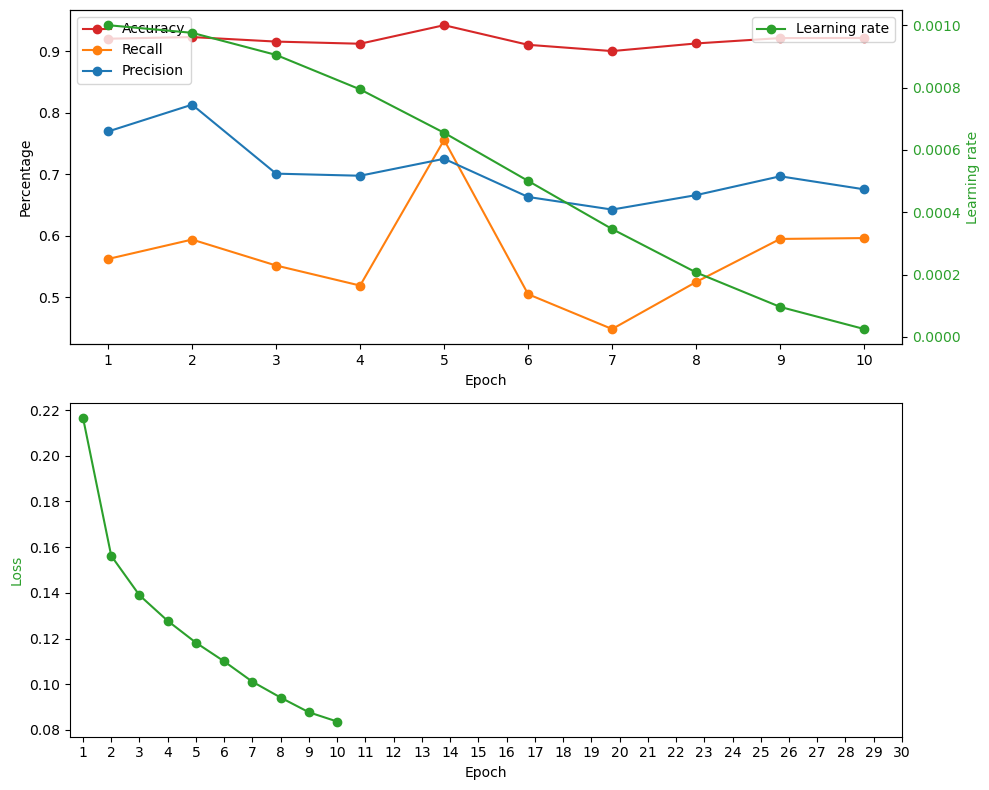

Training model...
     Epoch [11/30], Step [100/6322], Loss: 0.0416, Learning Rate: 1e-06
     Epoch [11/30], Step [200/6322], Loss: 0.0608, Learning Rate: 1e-06
     Epoch [11/30], Step [300/6322], Loss: 0.0391, Learning Rate: 1e-06
     Epoch [11/30], Step [400/6322], Loss: 0.0637, Learning Rate: 1e-06
     Epoch [11/30], Step [500/6322], Loss: 0.0430, Learning Rate: 1e-06
     Epoch [11/30], Step [600/6322], Loss: 0.0784, Learning Rate: 1e-06
     Epoch [11/30], Step [700/6322], Loss: 0.0239, Learning Rate: 1e-06
     Epoch [11/30], Step [800/6322], Loss: 0.0438, Learning Rate: 1e-06
     Epoch [11/30], Step [900/6322], Loss: 0.0619, Learning Rate: 1e-06
     Epoch [11/30], Step [1000/6322], Loss: 0.0534, Learning Rate: 1e-06
     Epoch [11/30], Step [1100/6322], Loss: 0.0445, Learning Rate: 1e-06
     Epoch [11/30], Step [1200/6322], Loss: 0.0738, Learning Rate: 1e-06
     Epoch [11/30], Step [1300/6322], Loss: 0.0861, Learning Rate: 1e-06
     Epoch [11/30], Step [1400/6322], Loss

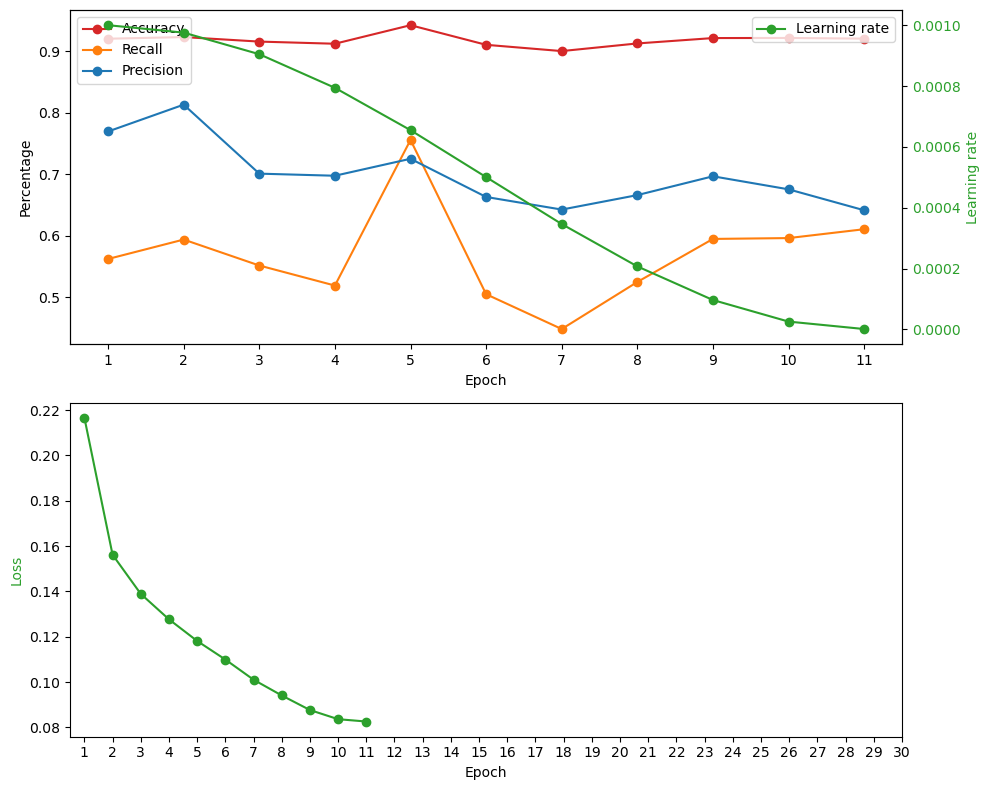

Training model...
     Epoch [12/30], Step [100/6322], Loss: 0.0463, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [200/6322], Loss: 0.0617, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [300/6322], Loss: 0.0429, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [400/6322], Loss: 0.0785, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [500/6322], Loss: 0.0836, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [600/6322], Loss: 0.0233, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [700/6322], Loss: 0.0860, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [800/6322], Loss: 0.0268, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [900/6322], Loss: 0.0241, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [1000/6322], Loss: 0.0806, Learning Rate: 2.5447270110570814e-05
     Epoch [12/30], Step [1100/6322], Loss: 0.0697, Learning Rate: 2.5447270110570814e-05
 

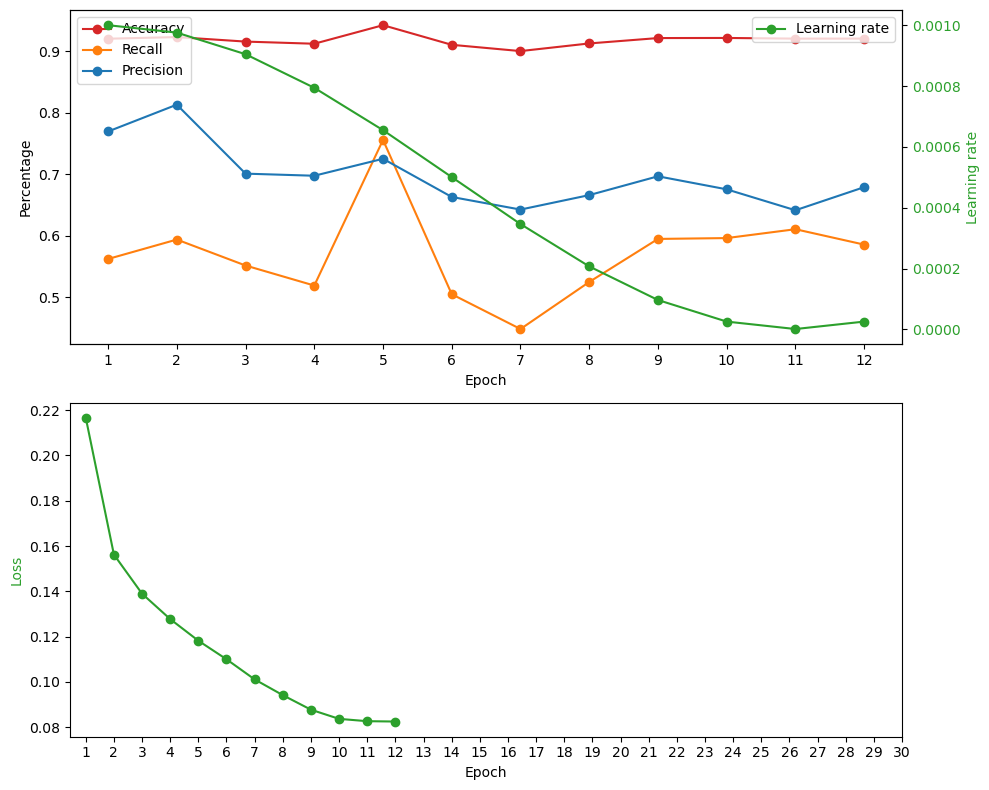

Training model...
     Epoch [13/30], Step [100/6322], Loss: 0.1209, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [200/6322], Loss: 0.0395, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [300/6322], Loss: 0.0178, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [400/6322], Loss: 0.2453, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [500/6322], Loss: 0.0541, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [600/6322], Loss: 0.0878, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [700/6322], Loss: 0.0418, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [800/6322], Loss: 0.0844, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [900/6322], Loss: 0.0468, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [1000/6322], Loss: 0.0526, Learning Rate: 9.639601130971418e-05
     Epoch [13/30], Step [1100/6322], Loss: 0.0425, Learning Rate: 9.639601130971418e-05
     Epoch [

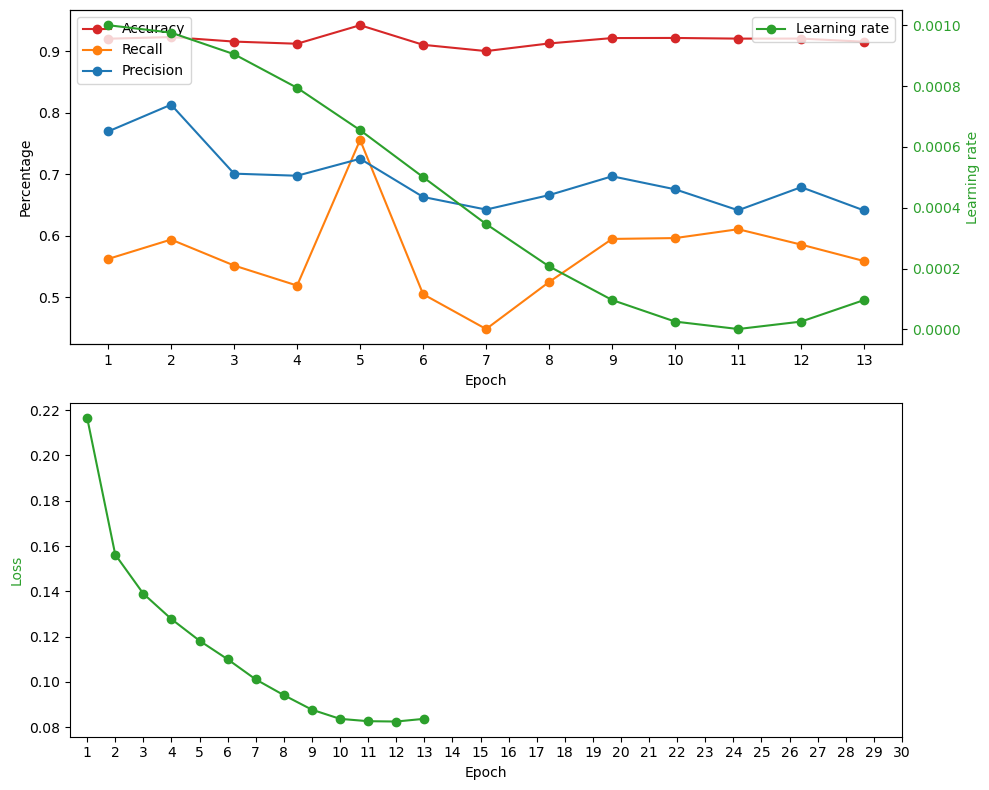

Training model...
     Epoch [14/30], Step [100/6322], Loss: 0.0622, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [200/6322], Loss: 0.0599, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [300/6322], Loss: 0.0473, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [400/6322], Loss: 0.0777, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [500/6322], Loss: 0.1130, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [600/6322], Loss: 0.0470, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [700/6322], Loss: 0.0401, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [800/6322], Loss: 0.0907, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [900/6322], Loss: 0.1502, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [1000/6322], Loss: 0.0618, Learning Rate: 0.00020690126647991054
     Epoch [14/30], Step [1100/6322], Loss: 0.1375, Learning Rate: 0.00020690126647991054
 

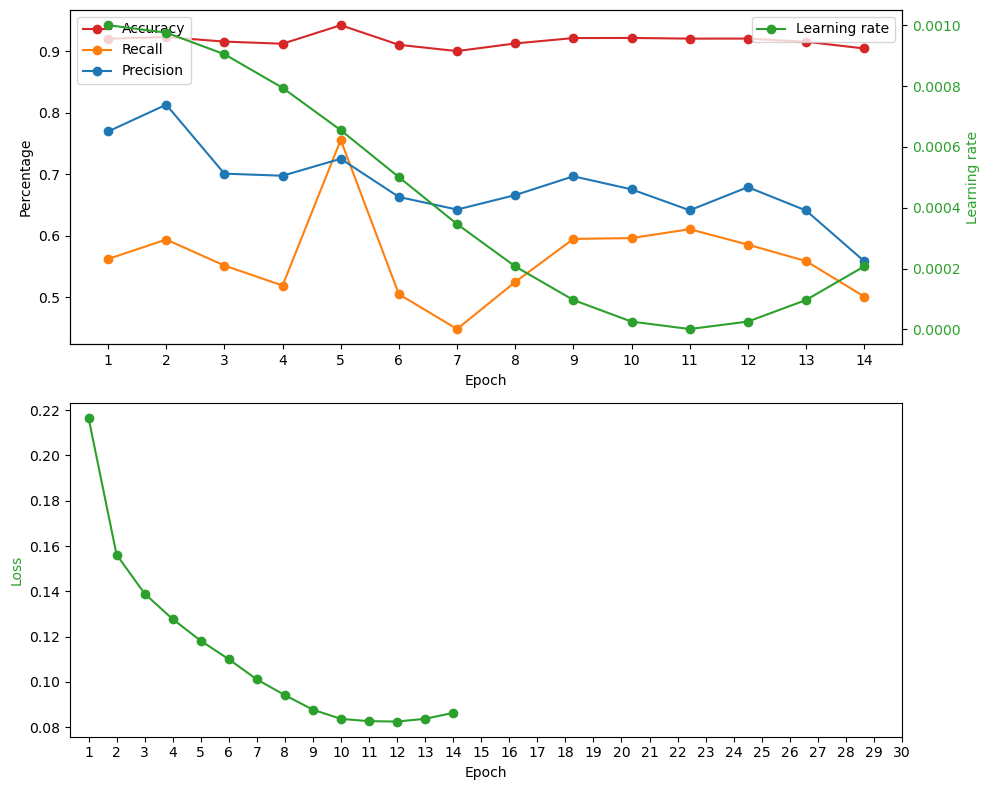

Training model...
     Epoch [15/30], Step [100/6322], Loss: 0.0679, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [200/6322], Loss: 0.0339, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [300/6322], Loss: 0.0456, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [400/6322], Loss: 0.0504, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [500/6322], Loss: 0.0622, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [600/6322], Loss: 0.0585, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [700/6322], Loss: 0.0596, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [800/6322], Loss: 0.0944, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [900/6322], Loss: 0.1630, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [1000/6322], Loss: 0.0800, Learning Rate: 0.0003461460113097153
     Epoch [15/30], Step [1100/6322], Loss: 0.0952, Learning Rate: 0.0003461460113097153
     Epoch [

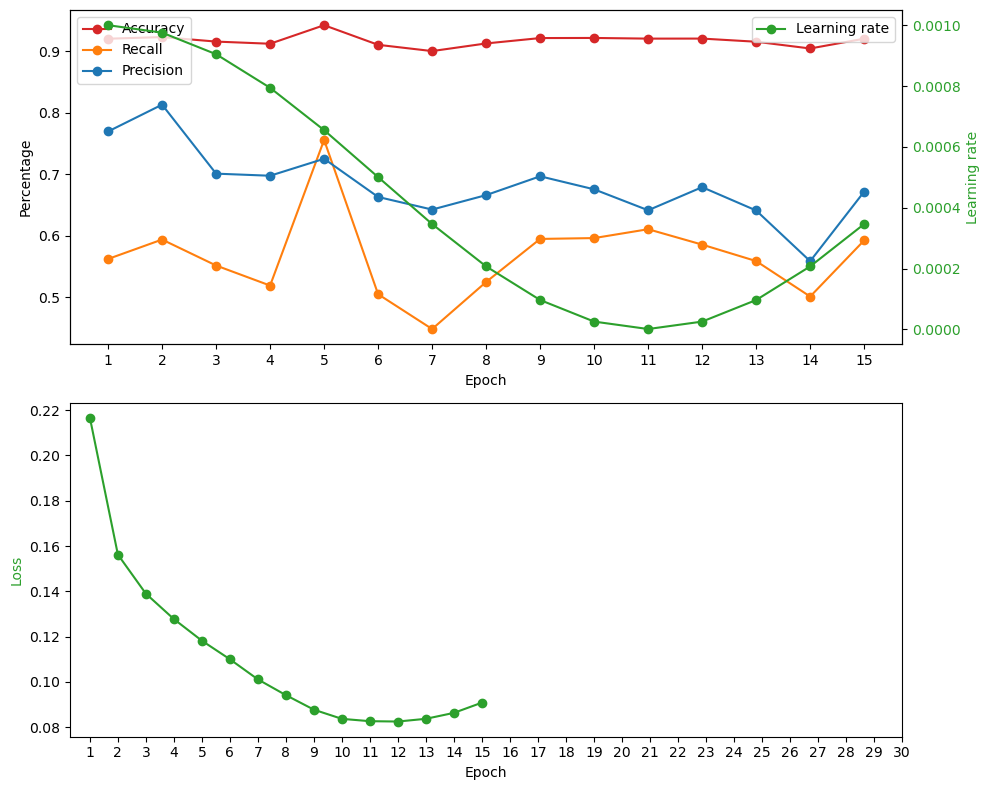

Training model...
     Epoch [16/30], Step [100/6322], Loss: 0.0281, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [200/6322], Loss: 0.0990, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [300/6322], Loss: 0.0367, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [400/6322], Loss: 0.0919, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [500/6322], Loss: 0.0773, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [600/6322], Loss: 0.0588, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [700/6322], Loss: 0.1141, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [800/6322], Loss: 0.1404, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [900/6322], Loss: 0.0791, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [1000/6322], Loss: 0.2154, Learning Rate: 0.0005005000000000021
     Epoch [16/30], Step [1100/6322], Loss: 0.0799, Learning Rate: 0.0005005000000000021
     Epoch [

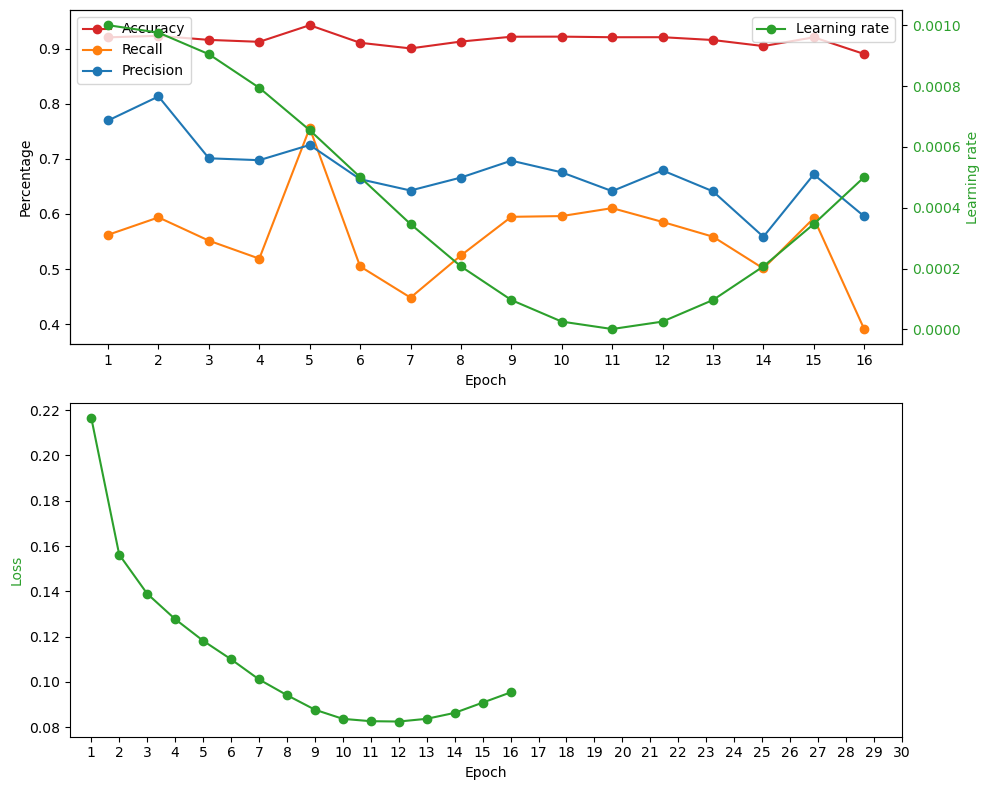

Training model...
     Epoch [17/30], Step [100/6322], Loss: 0.1027, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [200/6322], Loss: 0.0586, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [300/6322], Loss: 0.1288, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [400/6322], Loss: 0.0620, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [500/6322], Loss: 0.1676, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [600/6322], Loss: 0.0983, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [700/6322], Loss: 0.1737, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [800/6322], Loss: 0.1549, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [900/6322], Loss: 0.1262, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [1000/6322], Loss: 0.1079, Learning Rate: 0.0006548539886902891
     Epoch [17/30], Step [1100/6322], Loss: 0.1750, Learning Rate: 0.0006548539886902891
     Epoch [

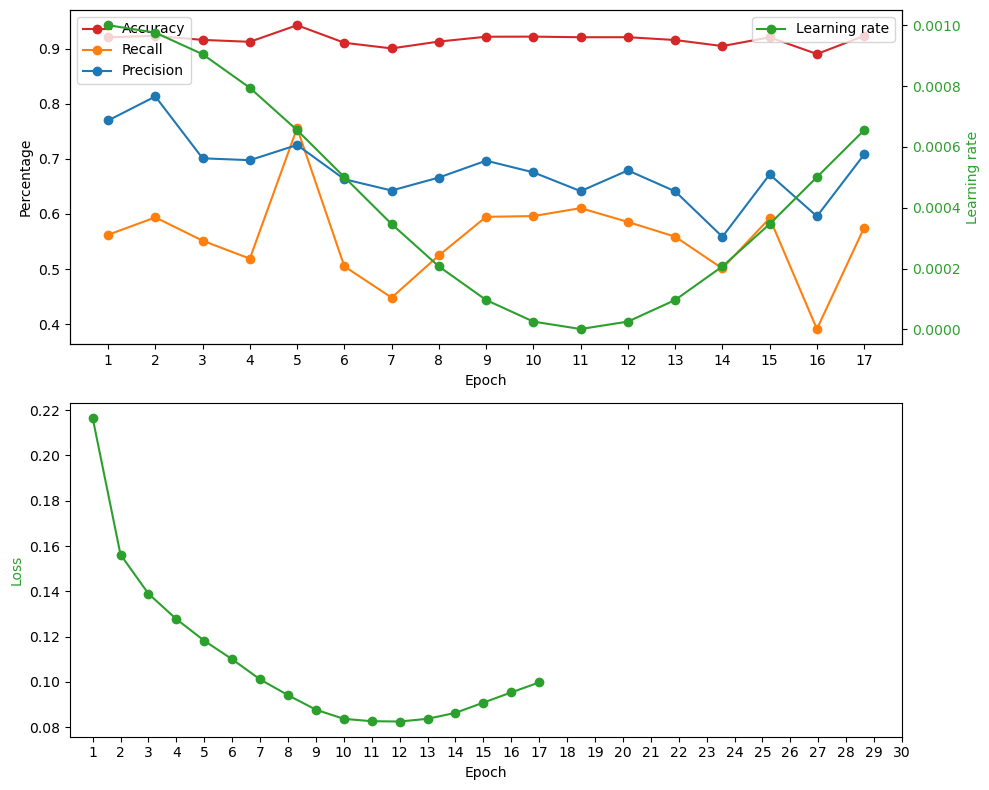

Training model...
     Epoch [18/30], Step [100/6322], Loss: 0.0573, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [200/6322], Loss: 0.0676, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [300/6322], Loss: 0.0474, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [400/6322], Loss: 0.1510, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [500/6322], Loss: 0.5239, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [600/6322], Loss: 0.1009, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [700/6322], Loss: 0.0544, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [800/6322], Loss: 0.1914, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [900/6322], Loss: 0.0639, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [1000/6322], Loss: 0.0476, Learning Rate: 0.0007940987335200938
     Epoch [18/30], Step [1100/6322], Loss: 0.0967, Learning Rate: 0.0007940987335200938
     Epoch [

KeyboardInterrupt: 

In [16]:
begin_epoch = 1
num_epochs = 30

class_weights = torch.tensor([1.0,1.0, 5.0]).to('cuda')
train_classification_model(model = model, train_loader=train_loader, val_loader= val_loader,save_model_dir=model_dir,
                           begin_epoch=begin_epoch,num_epochs=num_epochs,class_weights=class_weights, train=True, val=True)
